# Smart Charging Using Reinforcement Learning

In [14]:
import math
import numpy as np
import gym
from gym import Env
from gym.spaces import Discrete, Box
from keras.models import Sequential
from keras.layers import Dense, Flatten
from tensorflow.keras.optimizers.legacy import Adam, SGD
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
import matplotlib.pyplot as plt

## Create Environment

In [7]:
class EVChargingEnvironment(Env):
    def __init__(self):
        self.action_space = Discrete(NUM_ACTIONS)
        self.battery_limit = BATTERY_LIMIT
        self.battery_level = self.battery_limit
        self.energy_demand = 0

        # A state in the environment consists of battery level and time interval
        self.observation_space = np.array([Box(low=np.array([0]), high=np.array([self.battery_limit])), Box(low=np.array([0]), high = np.array([8]))])

        # Initialize first state
        self.current_time_index = 0
        self.state = np.array([self.battery_level, self.current_time_index])

        # Set time coefficient as defined above
        self.time_coefficients = [0.9, 0.91, 0.93, 0.94, 0.96, 0.97, 0.99, 1.0]

        # Charging rates in range 0, 7, 14, 22 kWh divided by 4 (because we charge only 15 minutes)
        self.charging_rates = [0, 1.75, 3.5, 5.5]
        self.charging_rates_scaled = [0, 0.25, 0.5, 1]

    def step(self, action):

        charging_rate = self.charging_rates[action]
        charging_rate_scaled = self.charging_rates_scaled[action]


        if self.battery_level + charging_rate > self.battery_limit:
            self.battery_level = self.battery_limit
        else:
            self.battery_level += charging_rate

        reward = self.time_coefficients[self.current_time_index] * math.exp(charging_rate_scaled) * (-1)
        reward = round(reward, 2)

        if charging_rate == 0:
            reward = 0

        self.current_time_index += 1

        # Update time index
        self.state[0] = int(self.battery_level)
        self.state[1] = self.current_time_index
    
        # Check if simulation is complete
        done = self.current_time_index == 8

        if done:
            # Get energy demand from normal distribution
            self.energy_demand = np.random.normal(30, 5)

            if self.battery_level < self.energy_demand:
                # We set a very high penalty of 10,000 because of the cost function resulting in high costs
                reward -= 1000

        return self.state, reward, done, {}

    def reset(self):

        self.battery_level = max(0, self.battery_level - self.energy_demand)

        self.current_time_index = 0
        self.state = np.array([int(self.battery_level), self.current_time_index])
        return self.state

#### Check Environment Functionality

In [8]:
NUM_ACTIONS = 4 # Action space contains 4 actions: zero, low, medium, high charging
NUM_TIME_INTERVALS = 8 # charging every 15 minutes from 2pm to 4pm
BATTERY_LIMIT = 58 # Assumption: 58 kWh (Netto) battery capacity

env = EVChargingEnvironment()

episodes = 1000

for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0

    print(f"Episode {episode}\nInitial State: {state}")

    while not done:
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        score += reward

        print(f"Action: {action} | New State: {n_state} | Reward: {reward} | Done: {done}")
    
    print(f"Episode {episode} - Score: {round(score,2)}\n{'*' * 50}")


Episode 1
Initial State: [58  0]
Action: 2 | New State: [58  1] | Reward: -1.48 | Done: False
Action: 2 | New State: [58  2] | Reward: -1.5 | Done: False
Action: 1 | New State: [58  3] | Reward: -1.19 | Done: False
Action: 3 | New State: [58  4] | Reward: -2.56 | Done: False
Action: 2 | New State: [58  5] | Reward: -1.58 | Done: False
Action: 3 | New State: [58  6] | Reward: -2.64 | Done: False
Action: 3 | New State: [58  7] | Reward: -2.69 | Done: False
Action: 3 | New State: [58  8] | Reward: -2.72 | Done: True
Episode 1 - Score: -16.36
**************************************************
Episode 2
Initial State: [31  0]
Action: 1 | New State: [32  1] | Reward: -1.16 | Done: False
Action: 1 | New State: [34  2] | Reward: -1.17 | Done: False
Action: 1 | New State: [36  3] | Reward: -1.19 | Done: False
Action: 2 | New State: [39  4] | Reward: -1.55 | Done: False
Action: 3 | New State: [45  5] | Reward: -2.61 | Done: False
Action: 3 | New State: [50  6] | Reward: -2.64 | Done: False
Actio

Action: 3 | New State: [20  4] | Reward: -2.56 | Done: False
Action: 0 | New State: [20  5] | Reward: 0 | Done: False
Action: 1 | New State: [21  6] | Reward: -1.25 | Done: False
Action: 1 | New State: [23  7] | Reward: -1.27 | Done: False
Action: 1 | New State: [25  8] | Reward: -1001.28 | Done: True
Episode 60 - Score: -1012.81
**************************************************
Episode 61
Initial State: [0 0]
Action: 3 | New State: [5 1] | Reward: -2.45 | Done: False
Action: 2 | New State: [9 2] | Reward: -1.5 | Done: False
Action: 2 | New State: [12  3] | Reward: -1.53 | Done: False
Action: 0 | New State: [12  4] | Reward: 0 | Done: False
Action: 1 | New State: [14  5] | Reward: -1.23 | Done: False
Action: 0 | New State: [14  6] | Reward: 0 | Done: False
Action: 0 | New State: [14  7] | Reward: 0 | Done: False
Action: 3 | New State: [19  8] | Reward: -1002.72 | Done: True
Episode 61 - Score: -1009.43
**************************************************
Episode 62
Initial State: [0 0]


## Deep Q-Network

In [9]:
def build_model(states, actions):
    model = Sequential()
    model.add(Flatten(input_shape=(1, 2)))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy, nb_actions=actions, nb_steps_warmup=1000, target_model_update=1e-2)
    return dqn

NUM_ACTIONS = 4 # Action space contains 4 actions: zero, low, medium, high charging
NUM_TIME_INTERVALS = 8 # charging every 15 minutes from 2pm to 4pm
BATTERY_LIMIT = 58 # Assumption: 58 kWh (Netto) battery capacity

env = EVChargingEnvironment()

states = env.observation_space.shape
actions = env.action_space.n

model = build_model(states, actions)
memory = SequentialMemory(limit=50000, window_length=1)


# DQN Boltzmann
bo_policy = BoltzmannQPolicy()
dqn_boltzmann = DQNAgent(model=model, memory=memory, policy=bo_policy, nb_actions=actions, nb_steps_warmup=1000, target_model_update=1e-2)
dqn_boltzmann.compile(Adam(lr=1e-3), metrics=['mae'])


# DQN e-greedy 0
e_0_policy = EpsGreedyQPolicy(eps=0)
dqn_e_0 = DQNAgent(model=model, memory=memory, policy=e_0_policy, nb_actions=actions, nb_steps_warmup=1000, target_model_update=1e-2)
dqn_e_0.compile(Adam(lr=1e-3), metrics=['mae'])


# DQN e-greedy 0.1
e_01_policy = EpsGreedyQPolicy(eps=0.1)
dqn_e_01 = DQNAgent(model=model, memory=memory, policy=e_01_policy, nb_actions=actions, nb_steps_warmup=1000, target_model_update=1e-2)
dqn_e_01.compile(Adam(lr=1e-3), metrics=['mae'])

2023-08-15 17:21:22.931910: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_5_2/bias/Assign' id:1537 op device:{requested: '', assigned: ''} def:{{{node dense_5_2/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_5_2/bias, dense_5_2/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-08-15 17:21:24.882122: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_4_3/kernel/Assign' id:1842 op device:{requested: '', assigned: ''} def:{{{node dense_4_3/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_4_3/kernel, dense_4_3/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, an

## Results

#### BoltzmannQPolicy

In [10]:
training_results_bo = dqn_boltzmann.fit(env, nb_steps=50000, visualize=False, verbose=1)

Training for 50000 steps ...
Interval 1 (0 steps performed)


2023-08-15 17:21:28.514534: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_5_1/BiasAdd' id:1468 op device:{requested: '', assigned: ''} def:{{{node dense_5_1/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_5_1/MatMul, dense_5_1/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


    1/10000 [..............................] - ETA: 1:15:11 - reward: -2.4500

2023-08-15 17:21:28.756092: W tensorflow/c/c_api.cc:304] Operation '{name:'count_22/Assign' id:2368 op device:{requested: '', assigned: ''} def:{{{node count_22/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_22, count_22/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


  993/10000 [=>............................] - ETA: 55s - reward: -2.5680

2023-08-15 17:21:35.110672: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_5_2/BiasAdd' id:1542 op device:{requested: '', assigned: ''} def:{{{node dense_5_2/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_5_2/MatMul, dense_5_2/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-08-15 17:21:35.666231: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_15/AddN' id:1802 op device:{requested: '', assigned: ''} def:{{{node loss_15/AddN}} = AddN[N=2, T=DT_FLOAT, _has_manual_control_dependencies=true](loss_15/mul, loss_15/mul_1)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-08-15 1

10000/10000 [==============================] - 249s 25ms/step - reward: -3.3686
1250 episodes - episode_reward: -26.949 [-1013.870, -9.490] - loss: 867.035 - mae: 56.888 - mean_q: -11.833

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 359s 36ms/step - reward: -2.0496
1250 episodes - episode_reward: -16.397 [-1017.190, -9.680] - loss: 134.121 - mae: 41.941 - mean_q: -7.335

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 494s 49ms/step - reward: -1.8427
1250 episodes - episode_reward: -14.742 [-20.670, -10.020] - loss: 103.156 - mae: 37.004 - mean_q: -6.911

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 265s 27ms/step - reward: -1.9423
1250 episodes - episode_reward: -15.539 [-1016.490, -8.970] - loss: 65.245 - mae: 35.666 - mean_q: -6.288

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 444s 44ms/step - reward: -1.8281
done, took 1812.057 seconds


In [11]:
results = dqn_boltzmann.test(env, nb_episodes=150, visualize=False)
print(np.mean(results.history['episode_reward']))

Testing for 150 episodes ...
Episode 1: reward: -13.780, steps: 8
Episode 2: reward: -15.460, steps: 8
Episode 3: reward: -12.820, steps: 8
Episode 4: reward: -12.480, steps: 8
Episode 5: reward: -14.120, steps: 8
Episode 6: reward: -14.120, steps: 8
Episode 7: reward: -13.780, steps: 8
Episode 8: reward: -14.120, steps: 8
Episode 9: reward: -14.120, steps: 8
Episode 10: reward: -13.780, steps: 8
Episode 11: reward: -15.120, steps: 8
Episode 12: reward: -15.460, steps: 8
Episode 13: reward: -13.780, steps: 8
Episode 14: reward: -11.190, steps: 8
Episode 15: reward: -12.820, steps: 8
Episode 16: reward: -12.820, steps: 8
Episode 17: reward: -12.820, steps: 8
Episode 18: reward: -15.460, steps: 8
Episode 19: reward: -15.460, steps: 8
Episode 20: reward: -14.120, steps: 8
Episode 21: reward: -16.530, steps: 8
Episode 22: reward: -13.780, steps: 8
Episode 23: reward: -15.460, steps: 8
Episode 24: reward: -14.120, steps: 8
Episode 25: reward: -12.820, steps: 8
Episode 26: reward: -15.120, s

In [12]:
NUM_ACTIONS = 4 # Action space contains 4 actions: zero, low, medium, high charging
NUM_TIME_INTERVALS = 8 # charging every 15 minutes from 2pm to 4pm
BATTERY_LIMIT = 58 # Assumption: 58 kWh (Netto) battery capacity

env = EVChargingEnvironment()
final_battery_levels = []
episode_rewards = []
episodes = 1000
policies = []

for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    rewards = 0
    init_battery = state[0]

    learned_policy = []
    #print(f"Episode {episode}\nInitial State: {state}")

    while not done:
        state = np.expand_dims(state, axis=0)
        q_values = dqn_boltzmann.compute_q_values(state)  # Get Q-values from the DQN
        learned_action = np.argmax(q_values)  # Choose action with highest Q-value
        learned_policy.append(learned_action)
        state, reward, done, _ = env.step(learned_action)
        rewards += reward
    
    print(f"Episode {episode} - Init Battery: {init_battery} - Actions: {learned_policy} - Final Battery: {state[0]} - Score: {round(rewards,2)}\n{'*' * 50}")

    
    episode_rewards.append(round(rewards,2))
    final_battery_levels.append(state[0])
    policies.append(learned_policy)

Episode 1 - Init Battery: 58 - Actions: [0, 1, 1, 1, 1, 1, 1, 2] - Final Battery: 58 - Score: -8.97
**************************************************
Episode 2 - Init Battery: 23 - Actions: [3, 1, 1, 2, 2, 2, 2, 2] - Final Battery: 50 - Score: -12.82
**************************************************
Episode 3 - Init Battery: 17 - Actions: [3, 3, 3, 1, 2, 2, 2, 2] - Final Battery: 49 - Score: -15.12
**************************************************
Episode 4 - Init Battery: 24 - Actions: [3, 1, 1, 2, 2, 2, 2, 2] - Final Battery: 51 - Score: -12.82
**************************************************
Episode 5 - Init Battery: 27 - Actions: [3, 1, 1, 1, 2, 2, 2, 2] - Final Battery: 51 - Score: -12.48
**************************************************
Episode 6 - Init Battery: 26 - Actions: [3, 1, 1, 1, 2, 2, 2, 2] - Final Battery: 51 - Score: -12.48
**************************************************
Episode 7 - Init Battery: 21 - Actions: [3, 3, 1, 1, 2, 2, 2, 2] - Final Battery: 50 - Sc

Episode 8 - Init Battery: 20 - Actions: [3, 3, 1, 2, 2, 2, 2, 2] - Final Battery: 50 - Score: -14.12
**************************************************
Episode 9 - Init Battery: 23 - Actions: [3, 3, 1, 1, 2, 2, 2, 2] - Final Battery: 51 - Score: -13.78
**************************************************
Episode 10 - Init Battery: 18 - Actions: [3, 3, 3, 1, 2, 2, 2, 2] - Final Battery: 50 - Score: -15.12
**************************************************
Episode 11 - Init Battery: 13 - Actions: [3, 3, 3, 2, 2, 2, 2, 2] - Final Battery: 47 - Score: -15.46
**************************************************
Episode 12 - Init Battery: 19 - Actions: [3, 3, 1, 2, 2, 2, 2, 2] - Final Battery: 49 - Score: -14.12
**************************************************
Episode 13 - Init Battery: 21 - Actions: [3, 3, 1, 1, 2, 2, 2, 2] - Final Battery: 50 - Score: -13.78
**************************************************
Episode 14 - Init Battery: 28 - Actions: [1, 1, 1, 2, 2, 2, 2, 2] - Final Battery: 5

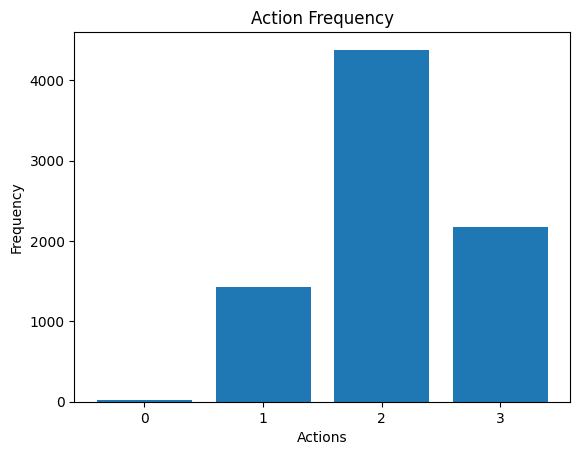

In [16]:

flattened_data = np.array(policies).flatten()
action_counts = np.bincount(flattened_data, minlength=4)
actions = np.arange(4)

# Create a bar plot
plt.bar(actions, action_counts)
plt.xlabel('Actions')
plt.ylabel('Frequency')
plt.title('Action Frequency')
plt.xticks(actions)
plt.show()

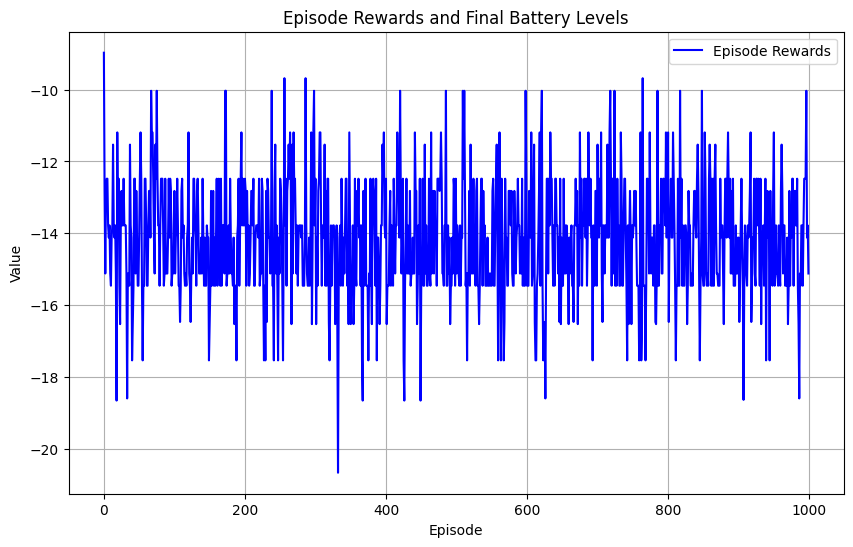

In [17]:
# Plot episode rewards with learnt policy
plt.figure(figsize=(10, 6))

# Plot episode rewards
plt.plot(episode_rewards, color='blue', label='Episode Rewards')

plt.title('Episode Rewards and Final Battery Levels')
plt.xlabel('Episode')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

#### EpsGreedyPolicy 0

In [18]:
training_results_e_0 = dqn_e_0.fit(env, nb_steps=50000, visualize=False, verbose=1)

Training for 50000 steps ...
Interval 1 (0 steps performed)
  989/10000 [=>............................] - ETA: 38s - reward: -1.8151

/home/lukas/.local/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-08-15 17:53:33.619460: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_5_3/BiasAdd' id:1876 op device:{requested: '', assigned: ''} def:{{{node dense_5_3/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_5_3/MatMul, dense_5_3/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-08-15 17:53:35.339927: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_19/AddN' id:2138 op device:{requested: '', assigned: ''} def:{{{node loss_19/AddN}} = AddN[N=2, T=DT_FLOAT, _has_manual_

10000/10000 [==============================] - 380s 38ms/step - reward: -1.8247
1250 episodes - episode_reward: -14.598 [-20.670, -9.660] - loss: 38.560 - mae: 28.285 - mean_q: -2.748

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 279s 28ms/step - reward: -1.8332
1250 episodes - episode_reward: -14.666 [-1018.280, -9.620] - loss: 14.604 - mae: 23.693 - mean_q: -6.680

Interval 3 (20000 steps performed)
 3182/10000 [========>.....................] - ETA: 3:27 - reward: -2.1014

In [ ]:
results = dqn_e_0.test(env, nb_episodes=150, visualize=False)
print(np.mean(results.history['episode_reward']))

In [ ]:
NUM_ACTIONS = 4 # Action space contains 4 actions: zero, low, medium, high charging
NUM_TIME_INTERVALS = 8 # charging every 15 minutes from 2pm to 4pm
BATTERY_LIMIT = 58 # Assumption: 58 kWh (Netto) battery capacity

env = EVChargingEnvironment()
final_battery_levels = []
episode_rewards = []
episodes = 1000
policies = []

for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    rewards = 0
    init_battery = state[0]

    learned_policy = []
    #print(f"Episode {episode}\nInitial State: {state}")

    while not done:
        state = np.expand_dims(state, axis=0)
        q_values = dqn_e_0.compute_q_values(state)  # Get Q-values from the DQN
        learned_action = np.argmax(q_values)  # Choose action with highest Q-value
        learned_policy.append(learned_action)
        state, reward, done, _ = env.step(learned_action)
        rewards += reward
    
    print(f"Episode {episode} - Init Battery: {init_battery} - Actions: {learned_policy} - Final Battery: {state[0]} - Score: {round(rewards,2)}\n{'*' * 50}")

    
    episode_rewards.append(round(rewards,2))
    final_battery_levels.append(state[0])
    policies.append(learned_policy)

In [ ]:
flattened_data = np.array(policies).flatten()
action_counts = np.bincount(flattened_data, minlength=4)
actions = np.arange(4)

# Create a bar plot
plt.bar(actions, action_counts)
plt.xlabel('Actions')
plt.ylabel('Frequency')
plt.title('Action Frequency')
plt.xticks(actions)
plt.show()

In [ ]:
# Plot episode rewards with learnt policy
plt.figure(figsize=(10, 6))

# Plot episode rewards
plt.plot(episode_rewards, color='blue', label='Episode Rewards')

plt.title('Episode Rewards and Final Battery Levels')
plt.xlabel('Episode')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

#### EpsGreedyPolicy 0.1

In [ ]:
training_results_e_01 = dqn_e_01.fit(env, nb_steps=50000, visualize=False, verbose=1)

In [ ]:
results = dqn_e_01.test(env, nb_episodes=150, visualize=False)
print(np.mean(results.history['episode_reward']))

In [ ]:
NUM_ACTIONS = 4 # Action space contains 4 actions: zero, low, medium, high charging
NUM_TIME_INTERVALS = 8 # charging every 15 minutes from 2pm to 4pm
BATTERY_LIMIT = 58 # Assumption: 58 kWh (Netto) battery capacity

env = EVChargingEnvironment()
final_battery_levels = []
episode_rewards = []
episodes = 1000
policies = []

for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    rewards = 0
    init_battery = state[0]

    learned_policy = []
    #print(f"Episode {episode}\nInitial State: {state}")

    while not done:
        state = np.expand_dims(state, axis=0)
        q_values = dqn_e_01.compute_q_values(state)  # Get Q-values from the DQN
        learned_action = np.argmax(q_values)  # Choose action with highest Q-value
        learned_policy.append(learned_action)
        state, reward, done, _ = env.step(learned_action)
        rewards += reward
    
    print(f"Episode {episode} - Init Battery: {init_battery} - Actions: {learned_policy} - Final Battery: {state[0]} - Score: {round(rewards,2)}\n{'*' * 50}")

    
    episode_rewards.append(round(rewards,2))
    final_battery_levels.append(state[0])
    policies.append(learned_policy)

In [ ]:
flattened_data = np.array(policies).flatten()
action_counts = np.bincount(flattened_data, minlength=4)
actions = np.arange(4)

# Create a bar plot
plt.bar(actions, action_counts)
plt.xlabel('Actions')
plt.ylabel('Frequency')
plt.title('Action Frequency')
plt.xticks(actions)
plt.show()

In [ ]:
# Plot episode rewards with learnt policy
plt.figure(figsize=(10, 6))

# Plot episode rewards
plt.plot(episode_rewards, color='blue', label='Episode Rewards')

plt.title('Episode Rewards and Final Battery Levels')
plt.xlabel('Episode')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()